# Temporal spectra and decorrelations


In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal

import crocosi.postp as pp
import phdequinox.sim_drifter as sdr

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)
#
client = Client(cluster)
#client = Client()
client

Client Scheduler: tcp://10.148.0.75:44271 Dashboard: http://10.148.0.75:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [3]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max=2, verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp75_4km_1500a2000j_itide/
Found 2 segments
Found 2 grid files
Found 4 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


In [4]:
#r['surf']

In [4]:
V = ['u', 'v']
dij = 4
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,14400,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 1 GB


In [5]:
ds

<xarray.Dataset>
Dimensions:       (time: 14400, x_rho: 65, x_u: 65, y_rho: 181, y_v: 181)
Coordinates:
    x_v           (x_rho) float32 dask.array<chunksize=(65,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
    f_rho         (y_rho) float32 0.0001029676 0.0001032268 ... 0.0001496236
  * y_rho         (y_rho) float32 -2000.0 14000.0 ... 2862000.0 2878000.0
    y_u           (y_rho) float32 dask.array<chunksize=(181,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 14000.0 ... 1006000.0 1022000.0
  * time          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    f_u           (y_rho) float32 dask.array<chunksize=(181,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
    f_v           (y_v) float32 0.000103 0.0001032592 ... 0.000149656
  * y_v           (y_v) float32 0.0 16000.0 32000.0 ... 2864000.0 2880000.0
  * x_u           (x_u) float32 0.0 16000.0 32000.0 ... 1008000.0 1024000.0
Data variables:
    u   

In [6]:
x, y, t = 10, 10, 6*24*20
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [7]:
ds = ds.persist()

In [8]:
#drifters
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

---

## Spectra: manual computation

In [11]:
# utility functions

def get_spectra_E(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def wrap_spectra(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = get_spectra_E(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(get_spectra_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': _kwargs['nperseg']}, kwargs=_kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [12]:
dt = float((ds.time[1]-ds.time[0]).values)
N = int(20/dt)
f, _ = wrap_spectra(ds.u.isel(x_u=0,y_rho=0), dt, nperseg=N)
E = wrap_spectra(ds.u, dt, f=f, nperseg=N)
E

<xarray.DataArray 'u' (y_rho: 181, x_u: 65, freq_time: 2879)>
dask.array<getitem, shape=(181, 65, 2879), dtype=float64, chunksize=(10, 10, 2879), chunktype=numpy.ndarray>
Coordinates:
    s_rho_slice0  float32 -0.01
    f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 14000.0 ... 2862000.0 2878000.0
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 16000.0 32000.0 ... 1008000.0 1024000.0
  * freq_time     (freq_time) float64 -71.97 -71.92 -71.87 ... 71.87 71.92 71.97

In [13]:
E_mean = E.mean('x_u').persist()

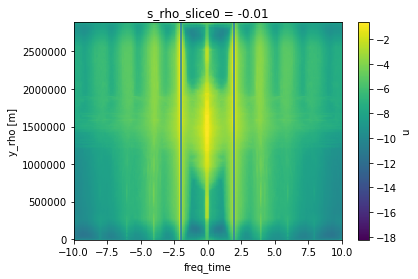

In [14]:
fig,ax = plt.subplots()
np.log10(E_mean).plot(ax=ax, x='freq_time', xlim=(-10,10))
ax.axvline(x=2.)
ax.axvline(x=-2.)

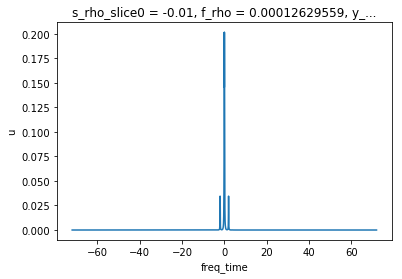

In [15]:
E_mean[int(E_mean.y_rho.size/2)].plot()

In [20]:
def time_window_processing(df, myfun, columns, T, N, overlap=0.5, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    tmin, tmax = p.index[0], p.index[-1]
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
    index = ['x','y']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<tmax:
        #
        _p = p.loc[t:t+T]
        # compute average position
        x, y = sdr.mean_position(_p, L)
        # apply myfun
        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

In [16]:
def get_spectrum(v, N, dt=None, method='welch', detrend='linear', **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
        
        method: string
            Method that will be employed for spectral calculations.
            Default is 'welch'
            
        detrend: boolean, optional
            Turns detrending on or off. Default is 'linear'.

    See: 
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    '''
    if v is None:
        _v = np.random.randn(N)
    else:
        _v = v.iloc[:N]
    if dt is None:
        dt = _v.reset_index()['index'].diff().mean()
    if detrend and not method=='welch':
        print('!!! Not implemented yet except for welch')    
    if method=='welch':
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1/dt, axis=0, **dkwargs)
    elif method=='mtspec':
        lE, f = mtspec(data=_v, delta=dt, time_bandwidth=4.,
                       number_of_tapers=6, quadratic=True)
    elif method=='mt':
        dkwargs = {'NW': 2, 'sides': 'twosided', 
                   'adaptive': False, 'jackknife': False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1/dt, **dkwargs)
        f = fftfreq(len(lf))*24.
        #print('Number of tapers = %d' %(nu[0]/2))
    return pd.Series(E, index=f)

In [17]:
def apply_twin_processing(dr, *args, **kwargs):
    ''' apply time_window_processing to dr.df and reset index properly
    '''
    df = dr.df.groupby(['id']).apply(time_window_processing, get_spectrum, ['u'], T, int(T/dt/2), dt=dt)
    _reset_index = lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
    return df.map_partitions(_reset_index)

In [22]:
import pandas as pd
T = 20
dt = 10./60./24.
L=1026
df_chunked = apply_twin_processing(dr, get_spectrum, ['u'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
Eu = df_chunked.groupby(['y_cut']).mean().compute()

ds_ft = (pd.melt(Eu.set_index(Eu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='frequency')
      .rename(columns={'y_cut': 'y_bins', 'value': 'Eu'})
      .set_index(['y_bins','frequency'])
      .to_xarray()
     )

ds

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


<xarray.Dataset>
Dimensions:       (time: 14400, x_rho: 65, x_u: 65, y_rho: 181, y_v: 181)
Coordinates:
    x_v           (x_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
    f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 14000.0 ... 2862000.0 2878000.0
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 14000.0 ... 1006000.0 1022000.0
  * time          (time) float64 dask.array<chunksize=(2880,), meta=np.ndarray>
    f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
    f_v           (y_v) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_v           (y_v) float32 0.0 16000.0 32000.0 ... 2864000.0 2880000.0
  * x_u           (x_u) float32 0.0 16000.0 32000.0 ... 1008000.0 1024000.0
Data variables

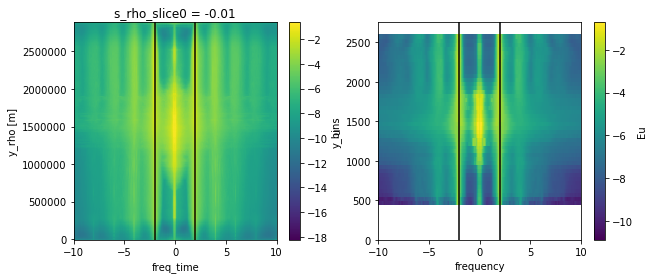

In [29]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
np.log10(E_mean).plot(ax=ax, x='freq_time', xlim=(-10,10))
ax.axvline(x=2.,c='k')
ax.axvline(x=-2.,c='k')
ax = fig.add_subplot(1,2,2)
np.log10(ds_ft.Eu).plot(x='frequency',y='y_bins',xlim=(-10,10))
ax.axvline(x=2.,c='k')
ax.axvline(x=-2.,c='k')

In [40]:
E_mean.sel(y_rho=1425e3,method='nearest')

<xarray.DataArray 'u' (freq_time: 2879)>
dask.array<getitem, shape=(2879,), dtype=float64, chunksize=(2879,), chunktype=numpy.ndarray>
Coordinates:
    s_rho_slice0  float32 -0.01
    f_rho         float32 dask.array<chunksize=(), meta=np.ndarray>
    y_rho         float32 1422000.0
    y_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    f_u           float32 dask.array<chunksize=(), meta=np.ndarray>
  * freq_time     (freq_time) float64 -71.97 -71.92 -71.87 ... 71.87 71.92 71.97

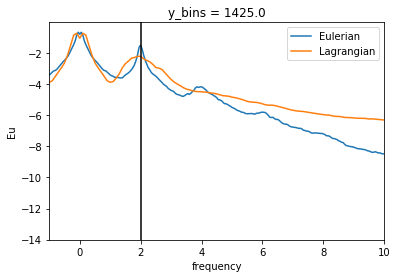

In [47]:
fig,ax = plt.subplots()
np.log10(E_mean.sel(y_rho=1425e3,method='nearest')).plot.line(label='Eulerian')

np.log10(ds_ft.Eu.isel(y_bins=int(ds_ft.Eu.y_bins.size/2)+1)).plot.line(x='frequency', xlim=(-1,10),label='Lagrangian')
ax.axvline(x=2.,c='k')
plt.legend()


---

## Spectra: xrft

---

## Decorrelations: manual apply_ufunc

In [48]:
# utility functions

def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True, **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'same'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'same', 'detrend': detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0., detrend=None, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1, _v2, **kwargs)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [49]:
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [50]:
dt = float((ds.time[1]-ds.time[0]).values)
_u = ds.u.isel(x_u=slice(0,2),y_rho=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(20/dt))

In [51]:
Cuu = wrap_correlate(ds.u, ds.u, dt, lags=lags, roll=True, Nr=int(20/dt))
Cuu_mean = Cuu.mean('x_u').persist()

distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.0.217:47407'], ('rechunk-merge-ae0396b809e6395b8e0a8849bced5d24', 0)
NoneType: None


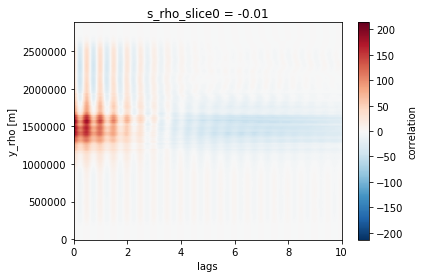

In [52]:
Cuu_mean.plot(x='lags')

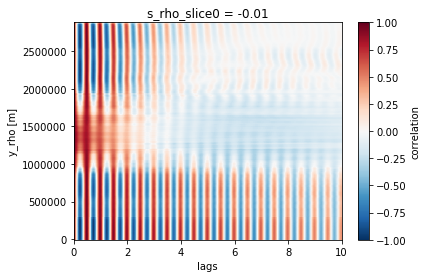

In [53]:
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).plot(x='lags')

---

### Drifters :

In [54]:
from scipy import signal


def correlate(v1, v2, N, detrend = False, dt=None):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N*2)
        _v2 = np.random.randn(N*2)
        if detrend:
            pass
        vv = np.correlate(_v1, _v2, mode='same')
    else:
        if detrend:
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        
        #print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        
        vv = np.correlate(v1, v2, mode='same')
    return pd.Series(vv[int(vv.size/2):][:N], index=np.arange(N)*dt)

In [55]:
import pandas as pd

df_chunked = dr.df.groupby(['id']).apply(time_window_processing, correlate, ['u','u'], T, int(T/dt/2), detrend=True,dt=dt)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

# show one partition:
#df_chunked.get_partition(0).compute()

# inspect df_chunked
df_chunked

Dask DataFrame Structure:
                  time        x        y      0.0 0.006944444444570763 0.013888888889141526 0.02083333333371229 0.027777777778283053 0.034722222222853816 0.04166666666742458 0.04861111111199534 0.055555555556566105 0.06250000000113687 0.06944444444570763 0.0763888888902784 0.08333333333484916 0.09027777777941992 0.09722222222399068 0.10416666666856145 0.11111111111313221 0.11805555555770297 0.12500000000227374 0.1319444444468445 0.13888888889141526 0.14583333333598603 0.1527777777805568 0.15972222222512755 0.16666666666969832 0.17361111111426908 0.18055555555883984 0.1875000000034106 0.19444444444798137 0.20138888889255213 0.2083333333371229 0.21527777778169366 0.22222222222626442 0.22916666667083518 0.23611111111540595 0.2430555555599767 0.2500000000045475 0.25694444444911824 0.263888888893689 0.27083333333825976 0.2777777777828305 0.2847222222274013 0.29166666667197205 0.2986111111165428 0.3055555555611136 0.31250000000568434 0.3194444444502551 0.32638888889482587 0.33333333333939663 0.3402777777839674 0.34722222222853816 0.3541666666731089 0.3611111111176797 0.36805555556225045 0.3750000000068212 0.381944444451392 0.38888888889596274 0.3958333333405335 0.40277777778510426 0.409722222229675 0.4166666666742458 0.42361111111881655 0.4305555555633873 0.4375000000079581 0.44444444445252884 0.4513888888970996 0.45833333334167037 0.46527777778624113 0.4722222222308119 0.47916666667538266 0.4861111111199534 0.4930555555645242 0.500000000009095 0.5069444444536657 0.5138888888982365 0.5208333333428072 0.527777777787378 0.5347222222319488 0.5416666666765195 0.5486111111210903 0.555555555565661 0.5625000000102318 0.5694444444548026 0.5763888888993733 0.5833333333439441 0.5902777777885149 0.5972222222330856 0.6041666666776564 0.6111111111222272 0.6180555555667979 0.6250000000113687 0.6319444444559394 0.6388888889005102 0.645833333345081 0.6527777777896517 0.6597222222342225 0.6666666666787933 0.673611111123364 0.6805555555679348 0.6875000000125056 0.6944444444570763 0.7013888889016471 0.7083333333462178 0.7152777777907886 0.7222222222353594 0.7291666666799301 0.7361111111245009 0.7430555555690717 0.7500000000136424 0.7569444444582132 0.763888888902784 0.7708333333473547 0.7777777777919255 0.7847222222364962 0.791666666681067 0.7986111111256378 0.8055555555702085 0.8125000000147793 0.81944444445935 0.8263888889039208 0.8333333333484916 0.8402777777930623 0.8472222222376331 0.8541666666822039 0.8611111111267746 0.8680555555713454 0.8750000000159162 0.8819444444604869 0.8888888889050577 0.8958333333496284 0.9027777777941992 0.90972222223877 0.9166666666833407 0.9236111111279115 0.9305555555724823 0.937500000017053 0.9444444444616238 0.9513888889061946 0.9583333333507653 0.9652777777953361 0.9722222222399068 0.9791666666844776 0.9861111111290484 0.9930555555736191 1.00000000001819 1.0069444444627607 1.0138888889073314 1.0208333333519022 1.027777777796473 1.0347222222410437 1.0416666666856145 1.0486111111301852 1.055555555574756 1.0625000000193268 1.0694444444638975 1.0763888889084683 1.083333333353039 1.0902777777976098 1.0972222222421806 1.1041666666867513 1.111111111131322 1.1180555555758929 1.1250000000204636 1.1319444444650344 1.1388888889096052 1.145833333354176 1.1527777777987467 1.1597222222433174 1.1666666666878882 1.173611111132459 1.1805555555770297 1.1875000000216005 1.1944444444661713 1.201388888910742 1.2083333333553128 1.2152777777998836 1.2222222222444543 1.229166666689025 1.2361111111335958 1.2430555555781666 1.2500000000227374 1.2569444444673081 1.263888888911879 1.2708333333564497 1.2777777778010204 1.2847222222455912 1.291666666690162 1.2986111111347327 1.3055555555793035 1.3125000000238742 1.319444444468445 1.3263888889130158 1.3333333333575865 1.3402777778021573 1.347222222246728 1.3541666666912988 1.3611111111358696 1.3680555555804403 1.375000000025011 1.3819444444695819 1.3888888889141526 1.3958333333587234 1.4027777778032942 1.409722222247865 1.4166666666924357 1.4236111111370064 1.430555555

In [57]:
y_bins = np.arange(0,2800,30)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
df_chunked

Dask DataFrame Structure:
                  time        x        y      0.0 0.006944444444570763 0.013888888889141526 0.02083333333371229 0.027777777778283053 0.034722222222853816 0.04166666666742458 0.04861111111199534 0.055555555556566105 0.06250000000113687 0.06944444444570763 0.0763888888902784 0.08333333333484916 0.09027777777941992 0.09722222222399068 0.10416666666856145 0.11111111111313221 0.11805555555770297 0.12500000000227374 0.1319444444468445 0.13888888889141526 0.14583333333598603 0.1527777777805568 0.15972222222512755 0.16666666666969832 0.17361111111426908 0.18055555555883984 0.1875000000034106 0.19444444444798137 0.20138888889255213 0.2083333333371229 0.21527777778169366 0.22222222222626442 0.22916666667083518 0.23611111111540595 0.2430555555599767 0.2500000000045475 0.25694444444911824 0.263888888893689 0.27083333333825976 0.2777777777828305 0.2847222222274013 0.29166666667197205 0.2986111111165428 0.3055555555611136 0.31250000000568434 0.3194444444502551 0.32638888889482587 0.33333333333939663 0.3402777777839674 0.34722222222853816 0.3541666666731089 0.3611111111176797 0.36805555556225045 0.3750000000068212 0.381944444451392 0.38888888889596274 0.3958333333405335 0.40277777778510426 0.409722222229675 0.4166666666742458 0.42361111111881655 0.4305555555633873 0.4375000000079581 0.44444444445252884 0.4513888888970996 0.45833333334167037 0.46527777778624113 0.4722222222308119 0.47916666667538266 0.4861111111199534 0.4930555555645242 0.500000000009095 0.5069444444536657 0.5138888888982365 0.5208333333428072 0.527777777787378 0.5347222222319488 0.5416666666765195 0.5486111111210903 0.555555555565661 0.5625000000102318 0.5694444444548026 0.5763888888993733 0.5833333333439441 0.5902777777885149 0.5972222222330856 0.6041666666776564 0.6111111111222272 0.6180555555667979 0.6250000000113687 0.6319444444559394 0.6388888889005102 0.645833333345081 0.6527777777896517 0.6597222222342225 0.6666666666787933 0.673611111123364 0.6805555555679348 0.6875000000125056 0.6944444444570763 0.7013888889016471 0.7083333333462178 0.7152777777907886 0.7222222222353594 0.7291666666799301 0.7361111111245009 0.7430555555690717 0.7500000000136424 0.7569444444582132 0.763888888902784 0.7708333333473547 0.7777777777919255 0.7847222222364962 0.791666666681067 0.7986111111256378 0.8055555555702085 0.8125000000147793 0.81944444445935 0.8263888889039208 0.8333333333484916 0.8402777777930623 0.8472222222376331 0.8541666666822039 0.8611111111267746 0.8680555555713454 0.8750000000159162 0.8819444444604869 0.8888888889050577 0.8958333333496284 0.9027777777941992 0.90972222223877 0.9166666666833407 0.9236111111279115 0.9305555555724823 0.937500000017053 0.9444444444616238 0.9513888889061946 0.9583333333507653 0.9652777777953361 0.9722222222399068 0.9791666666844776 0.9861111111290484 0.9930555555736191 1.00000000001819 1.0069444444627607 1.0138888889073314 1.0208333333519022 1.027777777796473 1.0347222222410437 1.0416666666856145 1.0486111111301852 1.055555555574756 1.0625000000193268 1.0694444444638975 1.0763888889084683 1.083333333353039 1.0902777777976098 1.0972222222421806 1.1041666666867513 1.111111111131322 1.1180555555758929 1.1250000000204636 1.1319444444650344 1.1388888889096052 1.145833333354176 1.1527777777987467 1.1597222222433174 1.1666666666878882 1.173611111132459 1.1805555555770297 1.1875000000216005 1.1944444444661713 1.201388888910742 1.2083333333553128 1.2152777777998836 1.2222222222444543 1.229166666689025 1.2361111111335958 1.2430555555781666 1.2500000000227374 1.2569444444673081 1.263888888911879 1.2708333333564497 1.2777777778010204 1.2847222222455912 1.291666666690162 1.2986111111347327 1.3055555555793035 1.3125000000238742 1.319444444468445 1.3263888889130158 1.3333333333575865 1.3402777778021573 1.347222222246728 1.3541666666912988 1.3611111111358696 1.3680555555804403 1.375000000025011 1.3819444444695819 1.3888888889141526 1.3958333333587234 1.4027777778032942 1.409722222247865 1.4166666666924357 1.4236111111370064 1.430555555

In [58]:
uu = df_chunked.groupby(['y_cut']).sum().compute()

In [59]:
# transform into 2D xarray
# column header need to be transformed into indices
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='lag')
      .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})
      .set_index(['y_bins','lag'])
      .to_xarray()
     )

In [70]:
print(ds['uu'].lag.values.size)
print(Cuu_mean.lags.values.size)

1439
1440


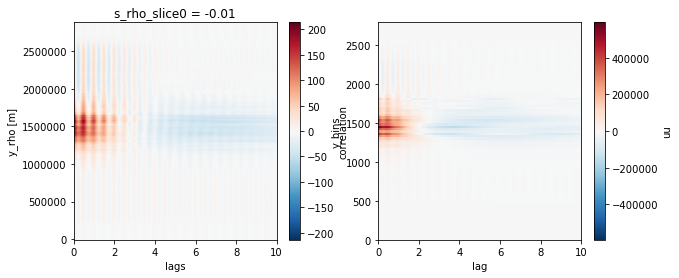

In [60]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
Cuu_mean.plot(ax=ax,x='lags')
ax = fig.add_subplot(1,2,2)
ds['uu'].plot(ax=ax)


[ 525. 1125. 1425. 1725. 2325.]
[ 526000. 1118000. 1422000. 1726000. 2318000.]


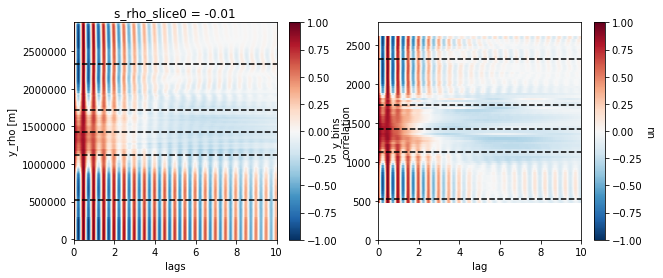

In [128]:
i_y = [17,37,47,57,77]
Bins = ds['uu'].y_bins.values
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).plot(x='lags')
ax.axhline(y=Bins[i_y[0]]*1000,c='k',linestyle='--')
ax.axhline(y=Bins[i_y[1]]*1000,c='k',linestyle='--')
ax.axhline(y=Bins[i_y[2]]*1000,c='k',linestyle='--')
ax.axhline(y=Bins[i_y[3]]*1000,c='k',linestyle='--')
ax.axhline(y=Bins[i_y[4]]*1000,c='k',linestyle='--')
ax = fig.add_subplot(1,2,2)
(ds['uu']/ds['uu'].sel(lag=0.)).plot(ax=ax)
ax.axhline(y=Bins[i_y[0]],c='k',linestyle='--')
ax.axhline(y=Bins[i_y[1]],c='k',linestyle='--')
ax.axhline(y=Bins[i_y[2]],c='k',linestyle='--')
ax.axhline(y=Bins[i_y[3]],c='k',linestyle='--')
ax.axhline(y=Bins[i_y[4]],c='k',linestyle='--')
print(Bins[i_y])
print(Cuu_mean.sel(y_rho=ds['uu'].y_bins[i_y]*1000,method='nearest').y_rho.values)#,ds['uu'].y_bins[60]*1000,ds['uu'].y_bins[20]*1000

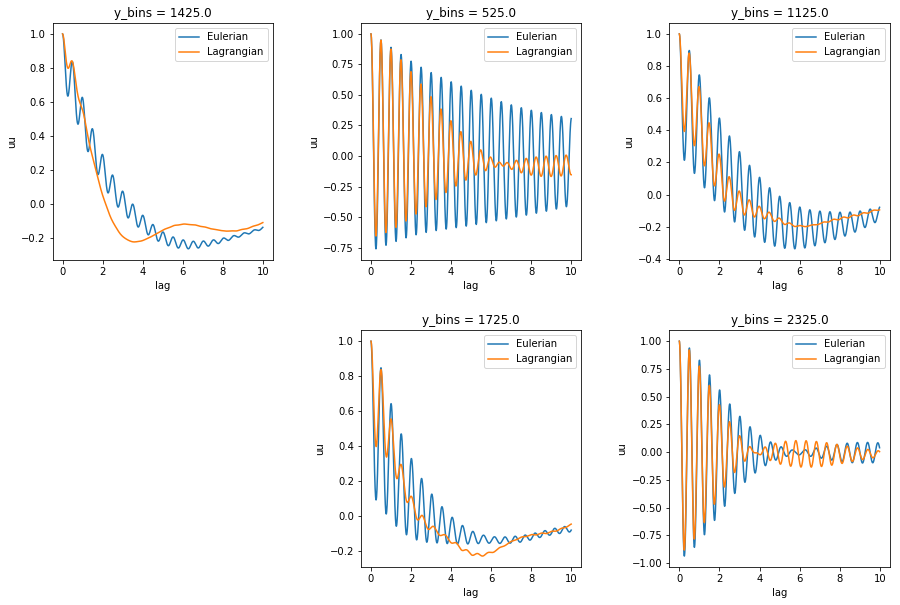

In [136]:
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
ax = plt.subplot(grid[0,0])
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).sel(y_rho=ds['uu'].y_bins[i_y[2]]*1000,method='nearest').isel(lags=slice(0,1439)).plot.line(ax=ax,x='lags', label='Eulerian')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=i_y[2]).plot.line(ax=ax,x='lag',label='Lagrangian')
plt.legend()
ax = plt.subplot(grid[0,1])
#ax = fig.add_subplot(2,2,1)
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).sel(y_rho=ds['uu'].y_bins[i_y[0]]*1000,method='nearest').isel(lags=slice(0,1439)).plot.line(ax=ax,x='lags', label='Eulerian')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=i_y[0]).plot.line(ax=ax,x='lag',label='Lagrangian')
plt.legend()
#ax = fig.add_subplot(2,2,2)
ax = plt.subplot(grid[0,2])
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).sel(y_rho=ds['uu'].y_bins[i_y[1]]*1000,method='nearest').isel(lags=slice(0,1439)).plot.line(ax=ax,x='lags', label='Eulerian')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=i_y[1]).plot.line(ax=ax,x='lag',label='Lagrangian')
plt.legend()
#ax = fig.add_subplot(2,2,3)
ax = plt.subplot(grid[1,1])
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).sel(y_rho=ds['uu'].y_bins[i_y[3]]*1000,method='nearest').isel(lags=slice(0,1439)).plot.line(ax=ax,x='lags', label='Eulerian')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=i_y[3]).plot.line(ax=ax,x='lag',label='Lagrangian')
plt.legend()
#ax = fig.add_subplot(2,2,4)
ax = plt.subplot(grid[1,2])
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).sel(y_rho=ds['uu'].y_bins[i_y[4]]*1000,method='nearest').isel(lags=slice(0,1439)).plot.line(ax=ax,x='lags', label='Eulerian')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=i_y[4]).plot.line(ax=ax,x='lag',label='Lagrangian')
plt.legend()


In [ ]:
cluster.close()